In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
def MLP(layers, activation=np.tanh):
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [3]:
@optimizers.optimizer
def sgd(step_size):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        return x0
    def update(i, g, x):
        return x - step_size(i) * g
    def get_params(x):
        return x
    return init, update, get_params

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [4]:
# Defining the keys for the model and the data loader:
# Doing this before due to some strange bug on JAX (REF:https://github.com/google/jax/issues/15084)
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [5]:
class MLPregression:
    # Initialize the class
    def __init__(self, layers, rng_key):
        # MLP init and apply functions
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets - outputs)**2)
        return loss 

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [6]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 norm_const=((0.0, 1.0), (0.0, 1.0)), 
                 batch_size=128, 
                 rng_key = random.PRNGKey(123)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.norm_const = norm_const
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        (mu_X, sigma_X), (mu_Y, sigma_Y) = self.norm_const
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx,:]
        inputs = (inputs - mu_X)/sigma_X
        targets = (targets - mu_Y)/sigma_Y
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [7]:
!wget https://github.com/maziarraissi/backprop/raw/master/training_data.csv
!wget https://github.com/maziarraissi/backprop/raw/master/test_data.csv

--2023-03-24 10:57:02--  https://github.com/maziarraissi/backprop/raw/master/training_data.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/backprop/master/training_data.csv [following]
--2023-03-24 10:57:03--  https://raw.githubusercontent.com/maziarraissi/backprop/master/training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5100 (5.0K) [text/plain]
Saving to: ‘training_data.csv.1’

training_data.csv.1 100%[===================>]   4.98K  --.-KB/s    in 0s      

2023-03-24 10:57:03 (57.5 MB/s) - ‘training_data.csv.1’ saved [5100/5100]

--2023-03-24 10:57:03--  ht

In [8]:
training_data = onp.loadtxt("training_data.csv")
X = np.array(training_data[:,0:1], dtype=np.float32)
Y = np.array(training_data[:,1:2], dtype=np.float32)

# Normalization constants
mu_X, sigma_X = X.mean(0), X.std(0)
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
norm_const = (mu_X, sigma_X), (mu_Y, sigma_Y)

dataset = DataGenerator(X, Y, norm_const, batch_size=32, rng_key = rng_dataloader)

In [9]:
layers=[1, 128, 128, 1]
model = MLPregression(layers, rng_key = rng_model)

In [10]:
model.train(dataset, nIter=10000)

100%|██████████| 10000/10000 [00:16<00:00, 624.31it/s, Loss=0.00031199254]


In [11]:
# Validate predictions
test_data = onp.loadtxt("test_data.csv")
X_test = np.array(test_data[:,0:1], dtype=np.float32)
Y_test = np.array(test_data[:,1:2], dtype=np.float32)

# Normalize test inputs
X_star = (X_test - mu_X)/sigma_X

# Predict
opt_params = model.get_params(model.opt_state)
Y_pred = model.predict(opt_params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

Error 3.043650e-02


Text(0, 0.5, 'Loss')

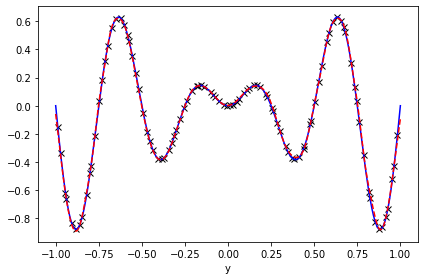

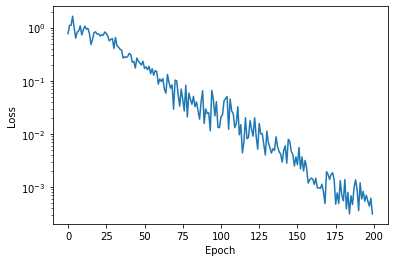

In [12]:
error = np.linalg.norm(Y_pred - Y_test)/np.linalg.norm(Y_test)
print('Error %e' %(error))

plt.figure()
plt.plot(X,Y,'kx')
plt.plot(X_test,Y_test,'b-')
plt.plot(X_test,Y_pred,'r--')
plt.xlabel('x')
plt.xlabel('y')
plt.tight_layout()

plt.figure()
plt.plot(np.array(model.loss_log))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')